# Introdução

O Southern Oscillation Index (SOI) corresponde à diferença mensal da pressão do ar na superfície do mar entre Darwin e Taiti. Esse projeto tem como objetivo analisar os dados do SOI e explorar alguns modelos de previsão de séries temporais.

Uma série temporal é um processo no qual uma dada observação depende de outros pontos de dados na mesma série. A análise visa explorar correlações dentro dos dados para entender-los e modelá-los e potencialmente prever a probabilidade de eventos futuros.

Ao analisar séries temporais, estamos interessados em como dois valores na série – separados por k intervalos de tempo, ou lag – afetam um ao outro.

Para a análise, o projeto foi dividido em:
*   **Análise exploratória:** nessa seção serão plotados os gráficos visando compreender melhor a relação temporal entre os índices.
*   **Decomposição em série temporal:** nessa parte iremos encontrar os componentes da série através de uma das bibliotecas.
* **Teste Dickey-Fuller**
*   **Modelos**:
    * Média Móvel
    * SARIMA
    * Outros (modelos de experimentação com o TensorFlow)  



# Imports

Nessa seção, serão realizados as importações das bibliotecas usadas no projeto.

In [ ]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from tqdm import tqdm_notebook
from itertools import product

# Dataset

Nessa seção, os dados serão carregados e manipulados com a biblioteca Pandas. Os dados foram retirados de https://www.ncei.noaa.gov/access/monitoring/enso/soi.

Os dados utilizados já estão normalizados e foram convertidos para um arquivo csv. Na conversão, os valores nulos do SOI a partir de Junho de 2023 foram substituídos por 0.

In [ ]:
df = pd.read_csv("/content/data.csv")
df

,YEAR,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,1951,1.5,0.9,-0.1,-0.3,-0.7,0.2,-1.0,-0.2,-1.1,-1.0,-0.8,-0.7
1,1952,-0.9,-0.6,0.5,-0.2,0.8,0.7,0.5,0.1,-0.2,0.4,0.0,-1.2
2,1953,0.3,-0.5,-0.2,0.2,-1.7,0.1,-0.0,-1.2,-1.2,0.1,-0.3,-0.5
3,1954,0.7,-0.3,0.3,0.6,0.5,0.1,0.4,1.1,0.2,0.3,0.1,1.4
4,1955,-0.5,1.9,0.6,-0.1,1.0,1.3,1.6,1.5,1.3,1.5,1.2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2019,-0.0,-1.4,-0.3,0.1,-0.4,-0.5,-0.4,-0.1,-1.2,-0.4,-0.8,-0.6
69,2020,0.2,-0.1,-0.1,0.2,0.4,-0.4,0.4,1.1,0.9,0.5,0.7,1.8
70,2021,1.9,1.5,0.4,0.3,0.5,0.4,1.4,0.6,0.8,0.7,1.0,1.5
71,2022,0.5,1.1,1.8,1.7,1.4,1.7,0.8,1.0,1.6,1.7,0.3,2.1


Agora, usaremos a função describe() do Pandas para visualizar as médias, desvios padrão e quartis de cada mês através dos anos.

In [ ]:
df_i = df.set_index('YEAR')
# aqui definimos a coluna dos anos como índice do dataframe
df_i.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
JAN,73.0,0.147945,1.204749,-3.5,-0.4,0.2,1.0,2.4
FEB,73.0,0.184932,1.302633,-3.6,-0.5,0.2,1.2,2.7
MAR,73.0,0.323288,1.034478,-2.4,-0.3,0.4,1.1,2.5
APR,73.0,0.160274,0.762805,-1.4,-0.3,0.1,0.8,1.9
MAY,73.0,0.142466,0.723018,-1.7,-0.4,0.3,0.5,1.4
JUN,73.0,0.183562,0.648077,-1.4,-0.3,0.2,0.6,1.7
JUL,73.0,0.120548,0.788627,-1.8,-0.4,0.2,0.6,1.9
AUG,73.0,0.182192,0.821473,-1.7,-0.3,0.2,0.7,2.0
SEP,73.0,0.045205,0.940898,-1.7,-0.7,0.1,0.7,2.2
OCT,73.0,0.121918,0.904502,-1.7,-0.4,0.1,0.8,1.8


E então será gerado um segundo dataframe com os mesmos valores mas com as linhas invertidas com as colunas. Dessa forma, será mais fácil plotar alguns gráficos na próxima seção.

Após isso, a função describe foi usada para gerar alguns parâmetros sobre o SOI através dos anos.

In [ ]:
df_t = df_i.T
df_t = df_t.rename(columns={'YEAR': 'MONTH'})
df_t.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
YEAR,,,,,,,,
1951,12.0,-0.275000,0.806930,-1.1,-0.850,-0.50,-0.025,1.5
1952,12.0,-0.008333,0.638832,-1.2,-0.300,0.05,0.500,0.8
1953,12.0,-0.408333,0.643087,-1.7,-0.675,-0.25,0.100,0.3
1954,12.0,0.450000,0.460237,-0.3,0.175,0.35,0.625,1.4
1955,12.0,1.025000,0.707267,-0.5,0.900,1.25,1.500,1.9
...,...,...,...,...,...,...,...,...
2019,12.0,-0.500000,0.451261,-1.4,-0.650,-0.40,-0.250,0.1
2020,12.0,0.466667,0.600505,-0.4,0.125,0.40,0.750,1.8
2021,12.0,0.916667,0.533996,0.3,0.475,0.75,1.425,1.9


Adicionalmente, será gerado um dataframe com apenas uma coluna, contendo os valores do índice SOI.

In [ ]:
# finalmente, gerando novo df com apenas uma coluna para todos os valores de SOI
df_single = df.drop(df.tail(1).index,inplace=True)
# primeiramente removemos o ano de 2023
df_single = df.drop(df.columns[0], axis=1)
df_single = df_single.stack().reset_index()
df_final = df_single.drop(df_single.columns[0], axis=1)
df_final = df_final.drop(df_single.columns[1], axis=1)
df_final = df_final.rename(columns={0: "SOI"})
df_final

,SOI
0,1.5
1,0.9
2,-0.1
3,-0.3
4,-0.7
...,...
847,0.6
848,0.8
849,0.7
850,1.0


Assim, para gerarmos as visualizações, podemos usar um dos três dataframes criados até agora:



*   **df:** dataframe contendo os dados originais
*   **df_i**: dataframe tendo os anos como índice
*   **df_t:** dataframe com as linhas transpostas pelas colunas
*   **df_final:** dataframe com apenas uma coluna

# Análise Exploratória

Nessa seção, a relação de tempo entre os dados será explorada através de visualizações de diferentes tipos de gráficos.

Primeiramente, serão gerados gráficos demonstrando a variação do SOI para cada mês em função dos anos.

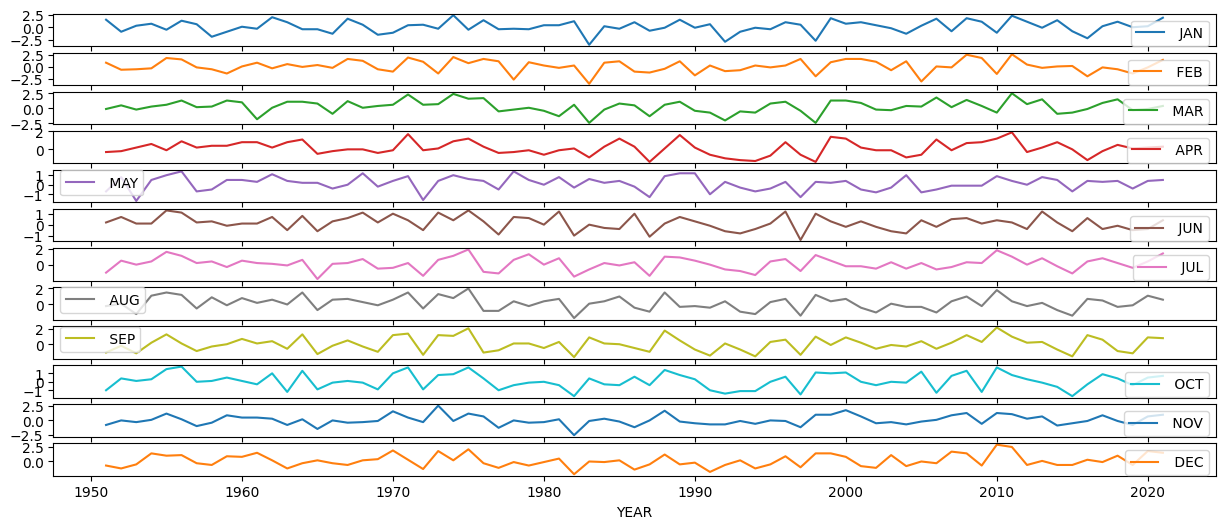

In [ ]:
plot_cols = [' JAN', ' FEB', ' MAR', ' APR', ' MAY', ' JUN', ' JUL', ' AUG', ' SEP', ' OCT', ' NOV', ' DEC']
plot_features = df[plot_cols]
plot_features.index = df['YEAR']
_ = plot_features.plot(subplots=True, figsize=(15, 6))

Através desse gráfico, é possível visualizar a clara relação entre os períodos de El Niño e La Niña através dos picos e depressões comuns entre os meses de um mesmo ano ou período de anos.

Para que a relação fique mais clara, podemos gerar um gráfico que mostre todos os meses sobrepostos em função dos anos.

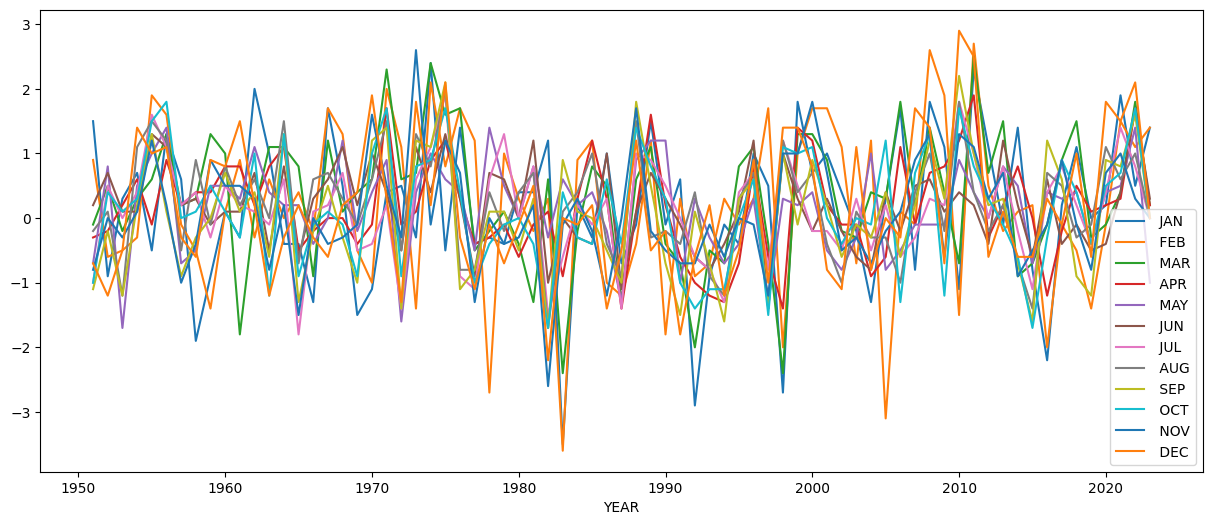

In [ ]:
df_i.plot(figsize=(15, 6))
plt.show()

Além disso, podemos visualizar as variações do SOI em relação a zero, de forma a evidenciar os valores negativos e positivos, ou seja, os períodos de El Niño e La Niña.

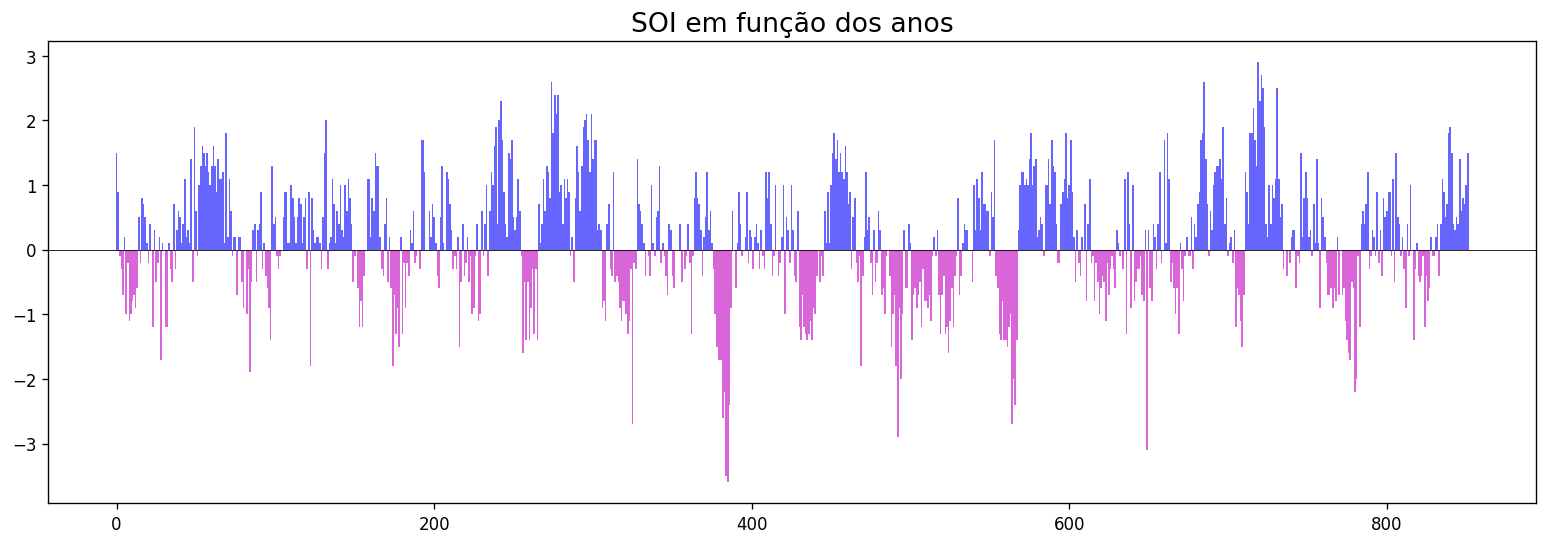

In [ ]:
y = df_final["SOI"]
plt.figure(figsize=(16,5), dpi=120)
plt.bar(df_final.index, y, color=np.where(y>0, 'b', 'm'), alpha=0.6, width=1)
plt.axhline(0, color='black', lw=0.5)
plt.title('SOI em função dos anos', fontsize=16)
plt.show()

A fase negativa do SOI, em rosa, representa a pressão do ar abaixo do normal no Tahiti, assim como a pressão do ar acima do normal em Darwin. É possível visualizar os períodos prolongados de valores negativos, correspondendo ao El Niño, enquanto os períodos em azul correspondem a La Niña.

# Decomposição da Série Temporal

Nessa seção, usaremos a função seasonal_decompose da biblioteca statsmodel para realizar a decomposição aditiva. Após isso, plotaremos os gráficos de cada componente.

O primeiro gráfico representa nossa série temporal original. O segundo gráfico representa a tendência do nosso modelo de série temporal extraído da série temporal original. Finalmente, o terceiro e o quarto gráficos representam sazonalidade e componentes residuais na mesma série temporal.

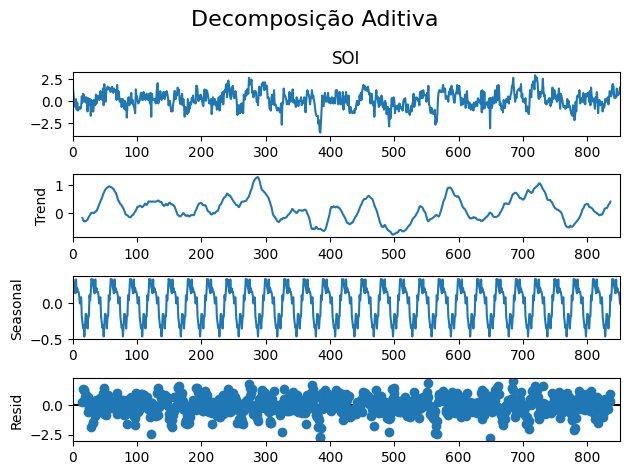

In [ ]:
# Foi usada a função seasonal_decompose da biblioteca statsmodels
additive_decomposition = seasonal_decompose(df_final['SOI'], model='additive', period=30)

# Plotando o gráfico
additive_decomposition.plot().suptitle('Decomposição Aditiva', fontsize=16)
plt.tight_layout()
plt.show()

# Teste Dickey-Fuller

Para determinar se os dados estão estacionários (o que sabemos que sim), iremos realizar o teste de Dickey-Fuller. A biblioteca statsmodels possui uma função para realizar o teste a partir de um conjunto de dados, que foi chamada dentro da função abaixo.

In [ ]:
data = df_final['SOI']

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


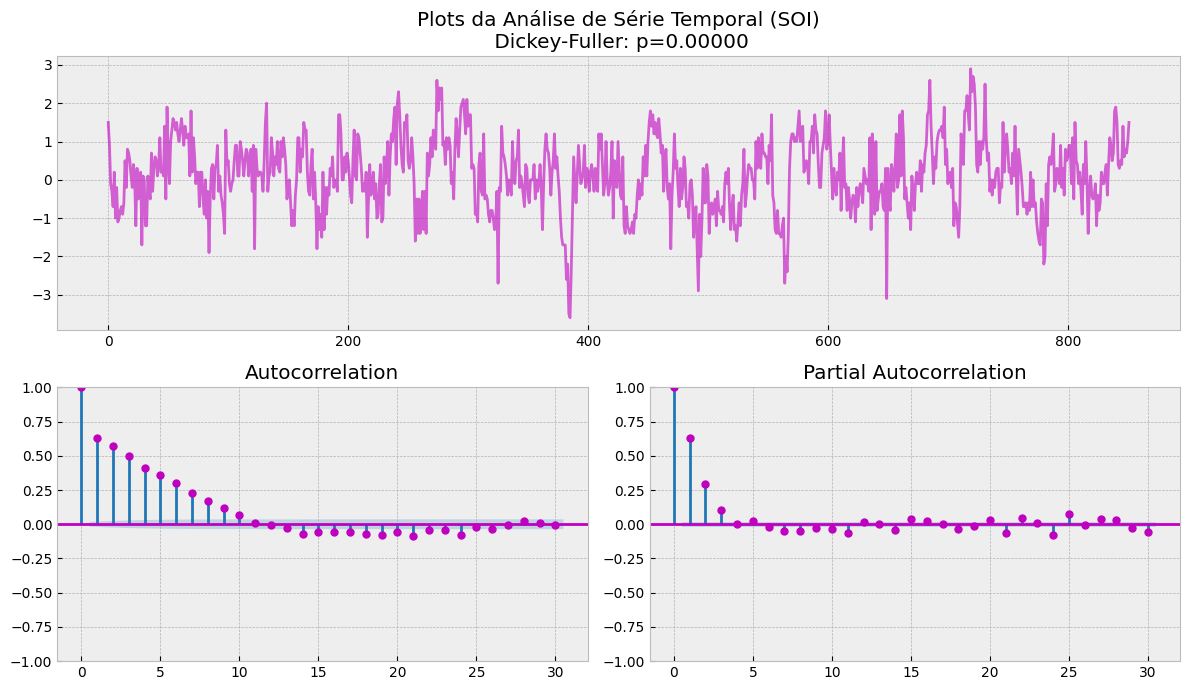

In [ ]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):

    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))

        y.plot(ax=ts_ax, color='m', alpha=0.6)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Plots da Análise de Série Temporal (SOI)\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, color='m', alpha=0.6)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, color='m', alpha=0.6)
        plt.tight_layout()

tsplot(data, lags=30)

# e podemos plotar mais um gráfico com a diferença para tornar o processo estacionário
# data_diff = data - data.shift(1)

# tsplot(data_diff[1:], lags=30)

Como esperado, o p-valor do teste foi igual a 0.0, confirmando que os dados são estacionários.

# Modelos

Nessa seção, iremos explorar alguns modelos para séries temporais.

## Média Movel

Primeiramente, vamos usar o modelo de média móvel para suavizar nossa série temporal. Para isso, usaremos uma função auxiliar que executará o modelo de média móvel em uma janela de tempo especificada e plotará a curva suavizada resultante. Para a função, foram usadas as bibliotecas numpy e scikit-learn.

<ipython-input-77-2c2a5b551ced>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g" (-> color=(0.0, 0.5, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(rolling_mean, 'g', label='Tendência de média contínua', color='black')


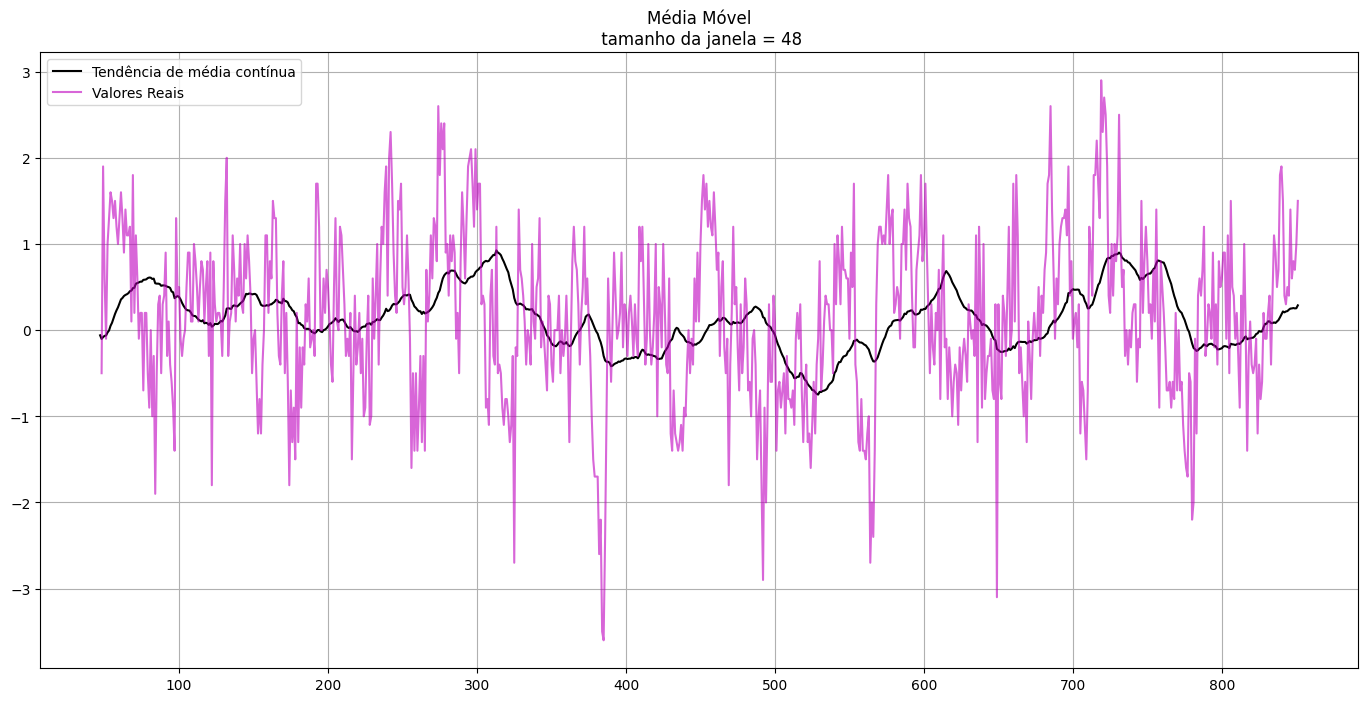

In [ ]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(17,8))
    plt.title('Média Móvel\n tamanho da janela = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Tendência de média contínua', color='black')

    if plot_intervals:
      mae = mean_absolute_error(series[window:], rolling_mean[window:])
      deviation = np.std(series[window:] - rolling_mean[window:])
      lower_bound = rolling_mean - (mae + scale * deviation)
      upper_bound = rolling_mean + (mae + scale * deviation)
      plt.plot(upper_bound, 'r--', label='Upper / Lower')
      plt.plot(lower_bound, 'r--')

    plt.plot(series[window:], label='Valores Reais', color='m', alpha=0.6)
    plt.legend(loc='best')
    plt.grid(True)

# o tamanho da janela de tempo foi definido para 48 meses, ou seja, 4 anos
plot_moving_average(df_final['SOI'], 48)

## SARIMA

Finalmente, o modelo usado será o SARIMA (Auto-Regressivo Integrado de
Médias Móveis com Sazonalidade).

Primeiro definimos alguns parâmetros e um intervalo de valores para outros parâmetros para gerar uma lista de todas as combinações possíveis de p, q, d, P, Q, D, s.



In [ ]:
#definindo valores iniciais e limites
ps = range(0, 5)
d = 1
qs = range(0, 5)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#criando lista com todas as combinações possíveis de parâmetros
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

Agora temos 625 combinações diferentes de parâmetros. Tentaremos cada combinação e treinaremos o SARIMA com cada uma delas para encontrar o modelo com melhor desempenho. A otimização será feita com a função abaixo, enquanto uma função do statsmodels será responsável por rodar o modelo SARIMA.

In [ ]:
# treinando diversos modelos SARIMA para encontrar a melhor combinação de parâmetros
def optimize_SARIMA(parameters_list, d, D, s):
    results = []
    best_aic = float('inf')

    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(data, order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue

        aic = model.aic

        # salvar melhor modelo a parâmetros
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #classificando em ordem crescente, sendo o menor AIC o melhor
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)

    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

#definindo como parâmetros os que fornecem o menor AIC
p, q, P, Q = result_table.parameters[0]

<ipython-input-108-c53d63609ef1>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/625 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

Feito isso, imprimimos um resumo do melhor modelo, com os parâmetros otimizados:

In [ ]:
best_model = sm.tsa.statespace.SARIMAX(data, order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                                 SOI   No. Observations:                  852
Model:             SARIMAX(4, 1, 4)x(0, 1, [1], 5)   Log Likelihood                -901.228
Date:                             Wed, 12 Jul 2023   AIC                           1822.456
Time:                                     04:19:21   BIC                           1869.861
Sample:                                          0   HQIC                          1840.619
                                             - 852                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9366      0.106     -8.833      0.000      -1.144      -0.729
ar.L2          0.3109      

## Outros

Nessa seção, serão testados outros modelos para o conjunto de dados fornecidos, utilizando o TensorFlow e outras funções prontas que não estão devidamente comentadas. Essa seção final foi usada somente como experimentação.

In [ ]:
df = df_final
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [ ]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [ ]:
w2 = WindowGenerator(input_width=73, label_width=1, shift=24,
                     label_columns=['SOI'])
w2

Total window size: 97
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
Label indices: [96]
Label column name(s): ['SOI']

In [ ]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 97, 1)
Inputs shape: (3, 73, 1)
Labels shape: (3, 1, 1)


In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='SOI', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Anos')

WindowGenerator.plot = plot

In [ ]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [ ]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    result = next(iter(self.train))
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['SOI'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['SOI']

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}
num_features = df.shape[1]

In [ ]:
baseline = Baseline(label_index=column_indices['SOI'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

6/6 [==============================] - 1s 7ms/step - loss: 0.7985 - mean_absolute_error: 0.6751


In [ ]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['SOI'])

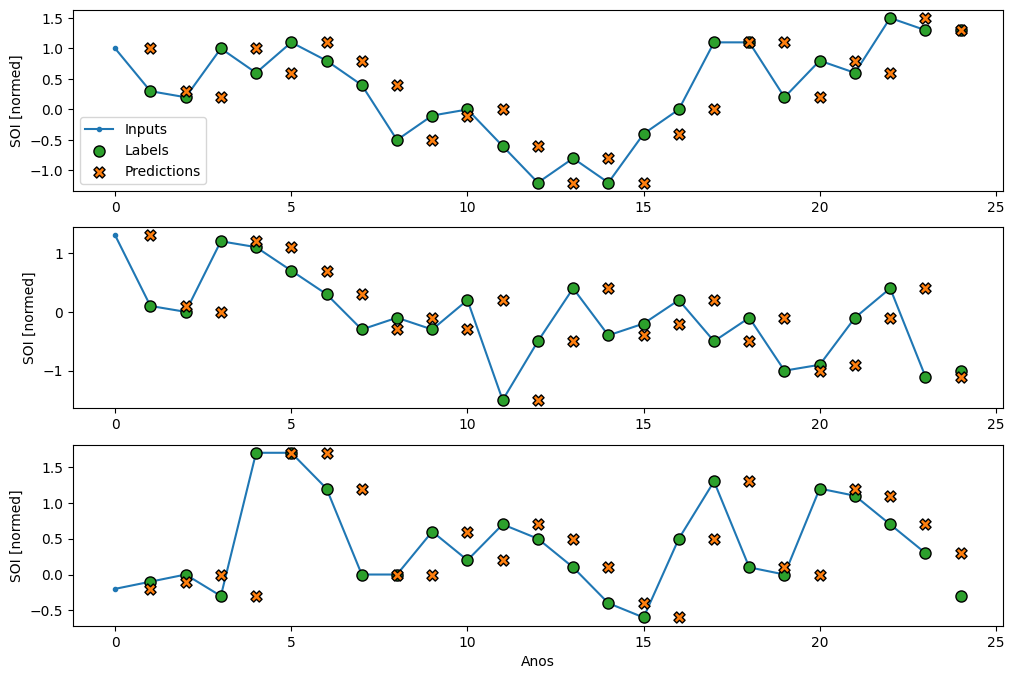

In [ ]:
wide_window.plot(baseline)

In [ ]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

5/5 [==============================] - 0s 6ms/step - loss: 0.5750 - mean_absolute_error: 0.5780


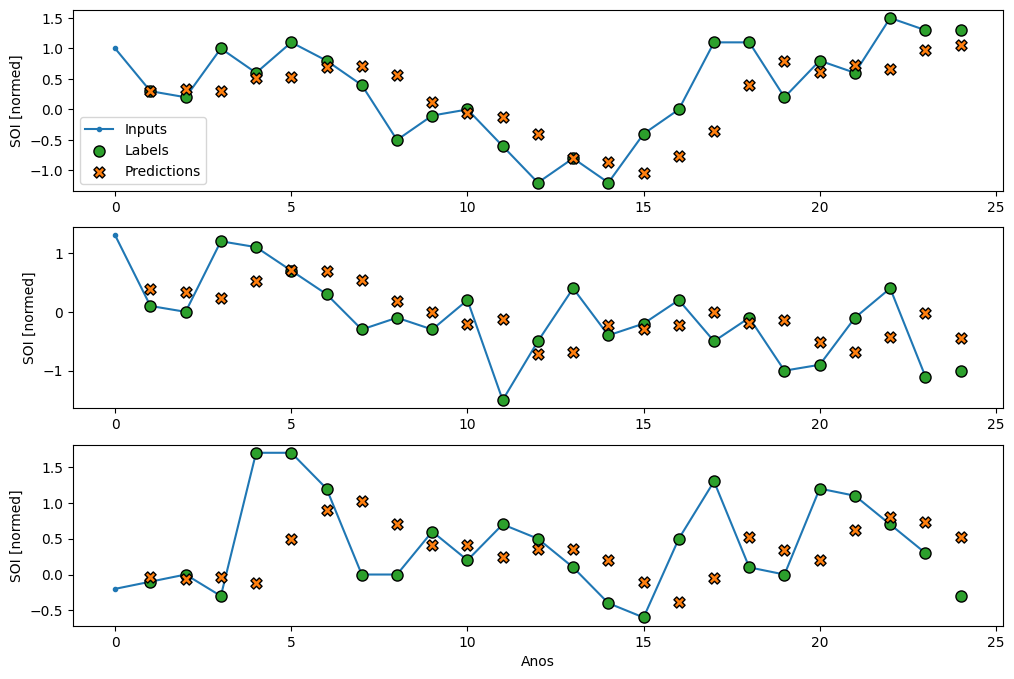

In [ ]:
wide_window.plot(lstm_model)

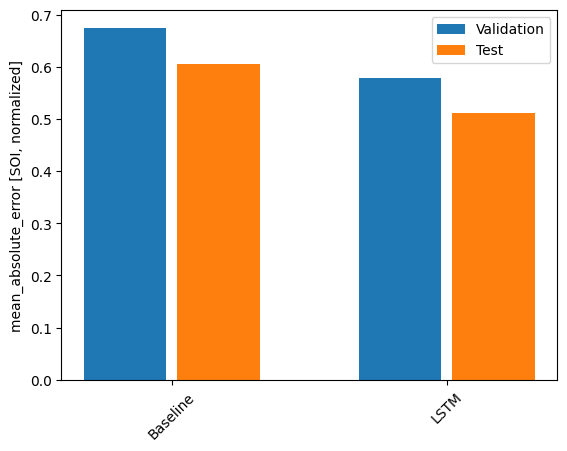

In [ ]:
# comparando os modelos do tensorflow
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [SOI, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()